In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
from src.functions import *
import random

import absl.logging #prevent checkpoint warnings while training
absl.logging.set_verbosity(absl.logging.ERROR)

import tensorflow as tf
tf.get_logger().setLevel('ERROR')
tf.autograph.set_verbosity(3)
from keras import backend as K
from tensorflow.python.client import device_lib
from src.config import *

reset_seed(seed = seed)

def get_available_devices():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos]
    
print("\n\n devices: ",get_available_devices()) 


%load_ext autoreload
%autoreload 2

%matplotlib inline
%config InlineBackend.figure_format = 'retina'




 devices:  ['/device:CPU:0', '/device:GPU:0']


2022-08-29 20:51:57.371432: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-08-29 20:51:57.413715: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-29 20:51:57.419632: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-29 20:51:57.420319: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

# Read data

### Load preprocessed dataset

In [5]:
from src.motion_refiner_4D import Motion_refiner

# base_folder = "/home/tum/data/"
# base_folder = "/home/mirmi/Arthur/data/" 

traj_n = 40
mr = Motion_refiner(load_models=True ,traj_n = traj_n, locality_factor=True)
feature_indices, obj_sim_indices, obj_poses_indices, traj_indices = mr.get_indices()
embedding_indices = np.concatenate([feature_indices,obj_sim_indices, obj_poses_indices])


loading BERT model... 

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


done
loading CLIP model... done


In [6]:

dataset_name = "4D_100k_scaping_factor"

X,Y, data = mr.load_dataset(dataset_name, filter_data = True, base_path=base_folder+"data/")
X_train, X_test, X_valid, y_train, y_test, y_valid, indices_train, indices_test, indices_val = mr.split_dataset(X, Y, test_size=0.2, val_size=0.1)


loading data... done
raw X: (100000, 953) 	Y: (100000, 160)
filtered X: (99092, 953) 	Y: (99092, 160)
Train X: (69363, 953) 	Y: (69363, 160)
Test  X: (19819, 953) 	Y: (19819, 160)
Val   X: (9910, 953) 	Y: (9910, 160)


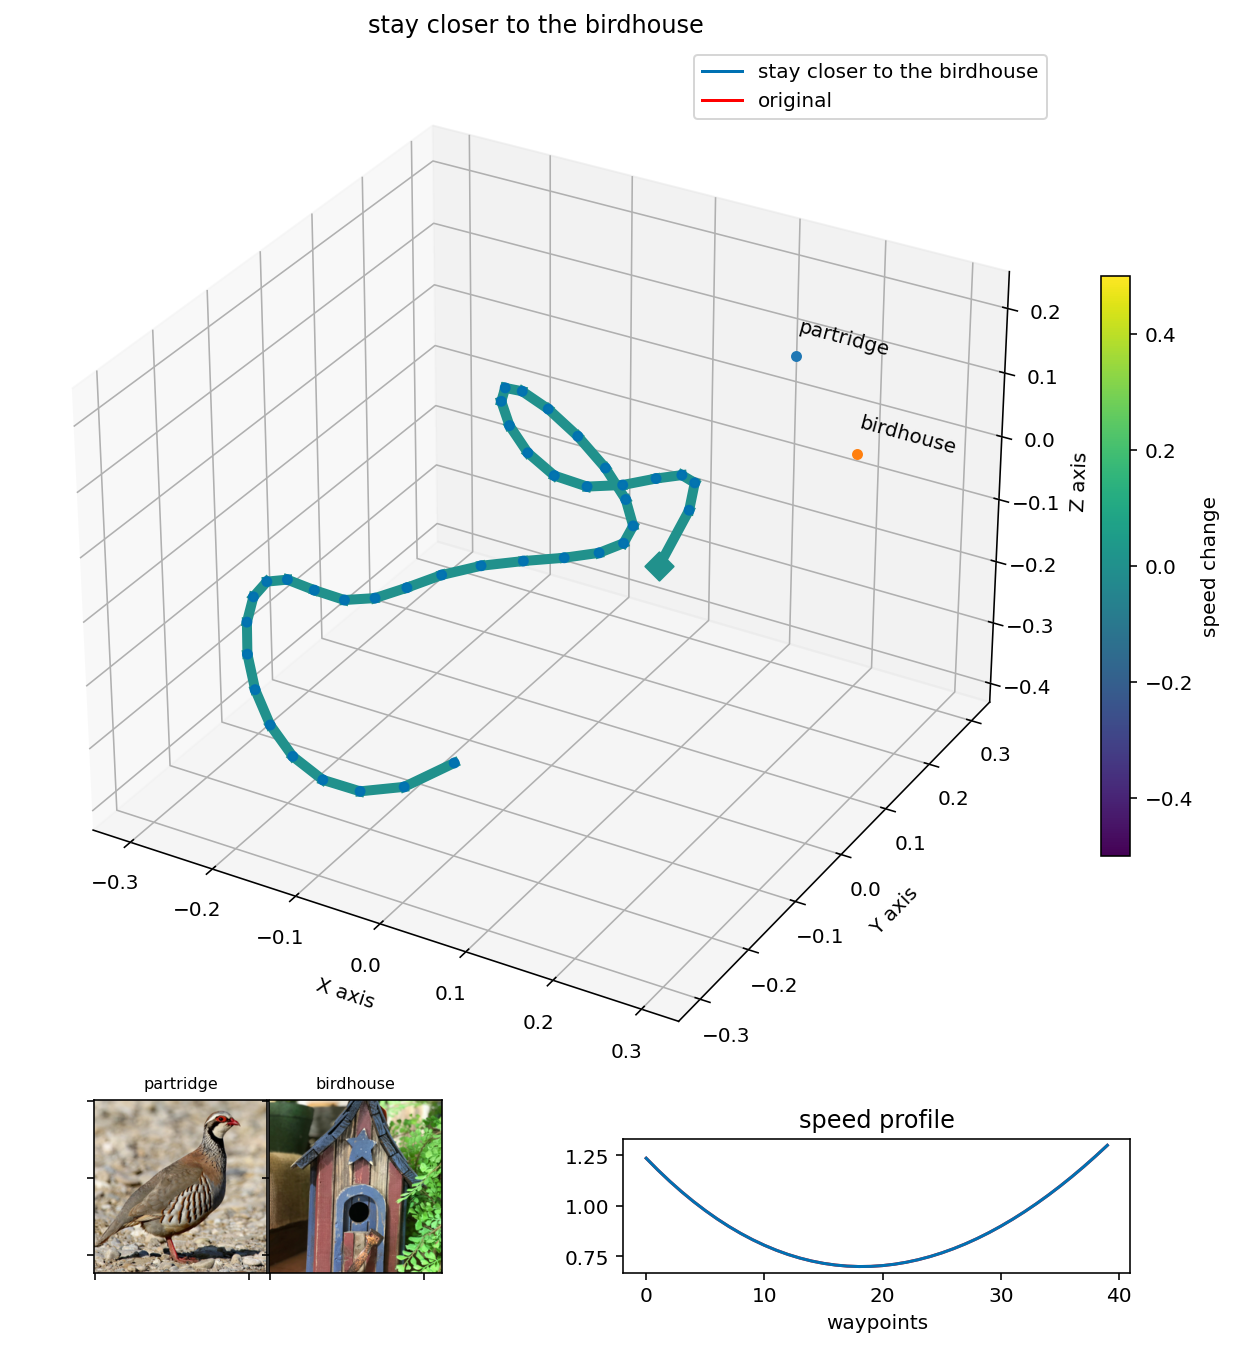

[70189]


In [8]:
#dataset sample
# %matplotlib qt
from src.functions import *
idx = random.choices(range(len(data)),k=1)
data_sample = list(np.array(data)[idx])
show_data4D(data_sample,image_loader=mr.image_loader, change_img_base=["/mnt/tumdata/image_dataset/", image_dataset_folder])
print(idx)

In [9]:

#object matching accuracy
mr.evaluate_obj_matching(data)

acc:  0.993531806762727


0.993531806762727

# Model

In [10]:

# from src.TF4D_ import *

# model_path = "/home/mirmi/Arthur/trajnlp_ws/src/NL_trajectory_reshaper/models/experimet_20220604-173050/"
# model_name =  "TF&num_layers_enc:2&num_layers_dec:4&d_model:256&dff:512&num_heads:8&dropout_rate:0.1&wp_d:4&bs:16&dense_n:512&num_dense:3&concat_emb:True&features_n:792&optimizer:adam&norm_layer:True&activation:linear.h5"

# model_path = base_folder+"models/TF4D_enc_dec_d/"
# model_name =  "TF&num_layers_enc:1&num_layers_dec:5&d_model:400&dff:512&num_heads:8&dropout_rate:0.1&wp_d:4&bs:16&dense_n:512&num_dense:3&concat_emb:True&features_n:792&optimizer:adam&norm_layer:True&activation:tanh.h5"

# model_path = models_folder+"TF4D_enc_dec_d/"

# model_name =  "TF&num_layers_enc:1&num_layers_dec:5&d_model:400&dff:512&num_heads:8&dropout_rate:0.1&wp_d:4&bs:16&dense_n:512&num_dense:3&concat_emb:True&features_n:792&optimizer:adam&norm_layer:True&activation:tanh.h5"
# model_file = model_path+model_name
# model = load_model(model_file, delimiter ="&")

from src.TF4D_mult_features import *
model_path = models_folder+"TF4D_embVec_enc_dec/"
model_name =  "TF-num_layers_enc:1-num_layers_dec:5-d_model:256-dff:512-num_heads:8-dropout_rate:0.1-wp_d:4-num_emb_vec:8-bs:16-dense_n:512-num_dense:3-concat_emb:True-features_n:792-optimizer:adam-norm_layer:True-activation:linear.h5"
model_file = model_path+model_name
model = load_model(model_file, delimiter ="-")


{'num_layers_enc': 1, 'num_layers_dec': 5, 'd_model': 256, 'dff': 512, 'num_heads': 8, 'dropout_rate': 0.1, 'wp_d': 4, 'num_emb_vec': 8, 'bs': 16, 'dense_n': 512, 'num_dense': 3, 'concat_emb': True, 'features_n': 792, 'optimizer': 'adam', 'norm_layer': True, 'activation': 'linear'}


2022-08-29 20:57:05.210401: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-29 20:57:05.210870: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-29 20:57:05.211287: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-29 20:57:05.211841: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-29 20:57:05.212277: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from S

loading weights:  /home/arthur/data/models/TF4D_embVec_enc_dec/TF-num_layers_enc:1-num_layers_dec:5-d_model:256-dff:512-num_heads:8-dropout_rate:0.1-wp_d:4-num_emb_vec:8-bs:16-dense_n:512-num_dense:3-concat_emb:True-features_n:792-optimizer:adam-norm_layer:True-activation:linear.h5


In [11]:
# def prepare_x(x):
#   objs = pad_array(list_to_wp_seq(x[:,obj_poses_indices],d=3),4,axis=-1) # no speed
#   trajs = list_to_wp_seq(x[:,traj_indices],d=4)
#   return np.concatenate([objs,trajs],axis = 1)

x_test_new, y_test_new = mr.prepare_x(X_test), list_to_wp_seq(y_test,d=4)
emb_test_new = X_test[:,embedding_indices]

# x_test_new, y_test_new, emb_test_new= increase_dataset(X_test ,y_test,embedding_indices,10)


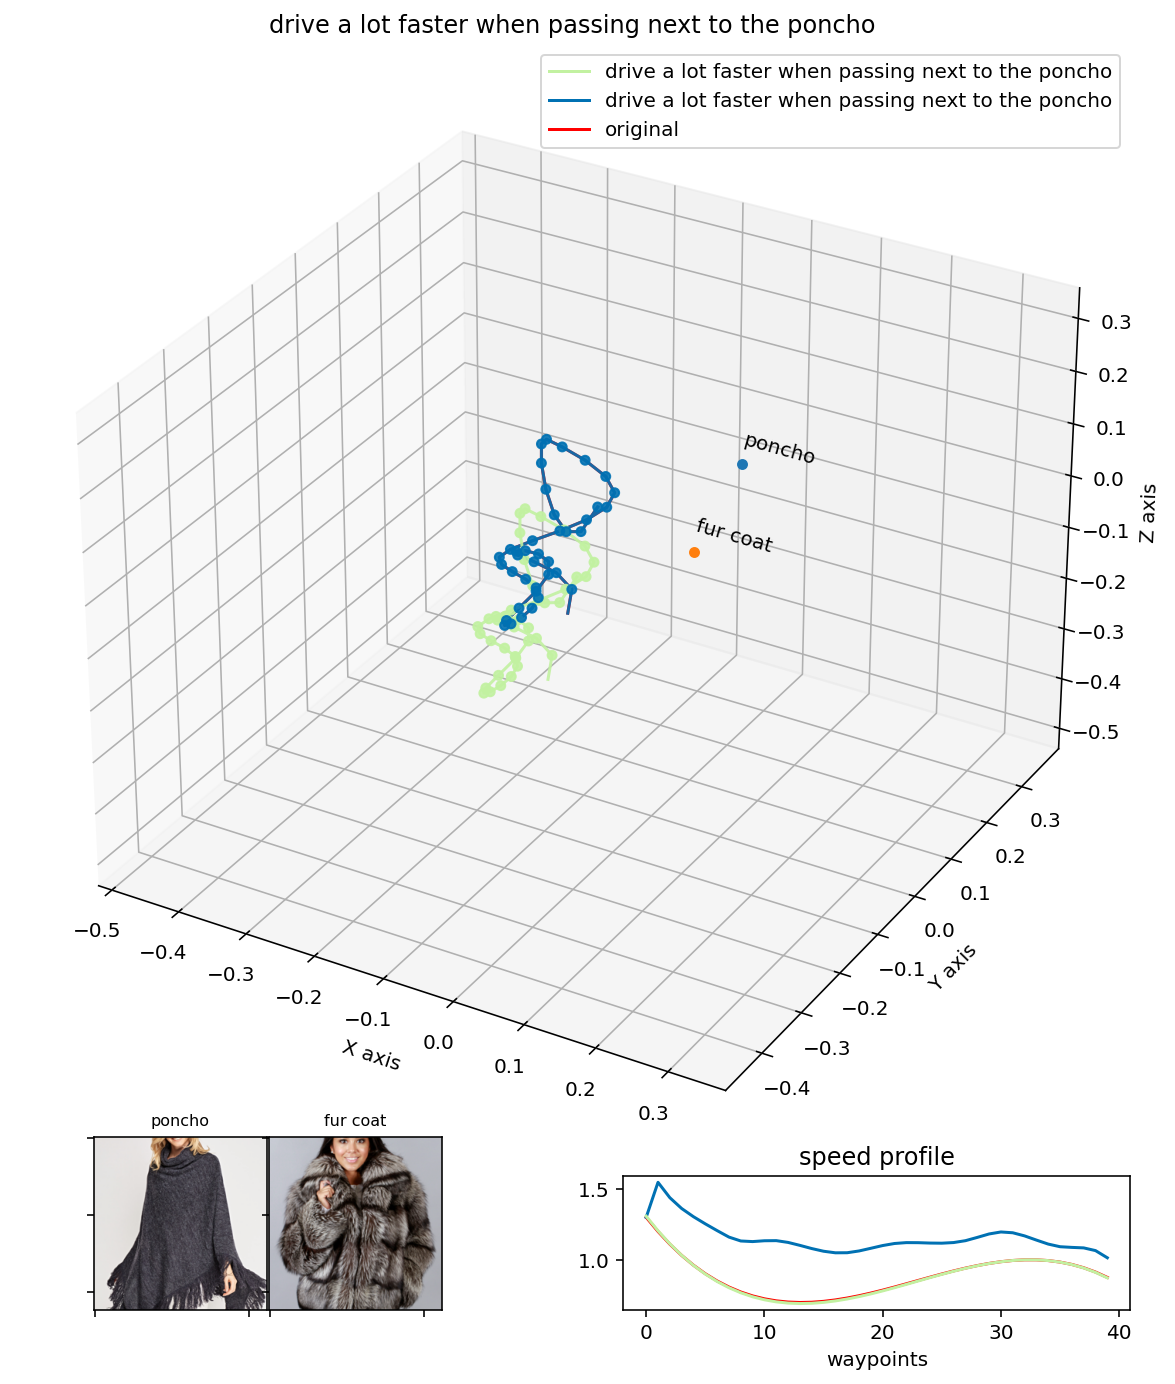

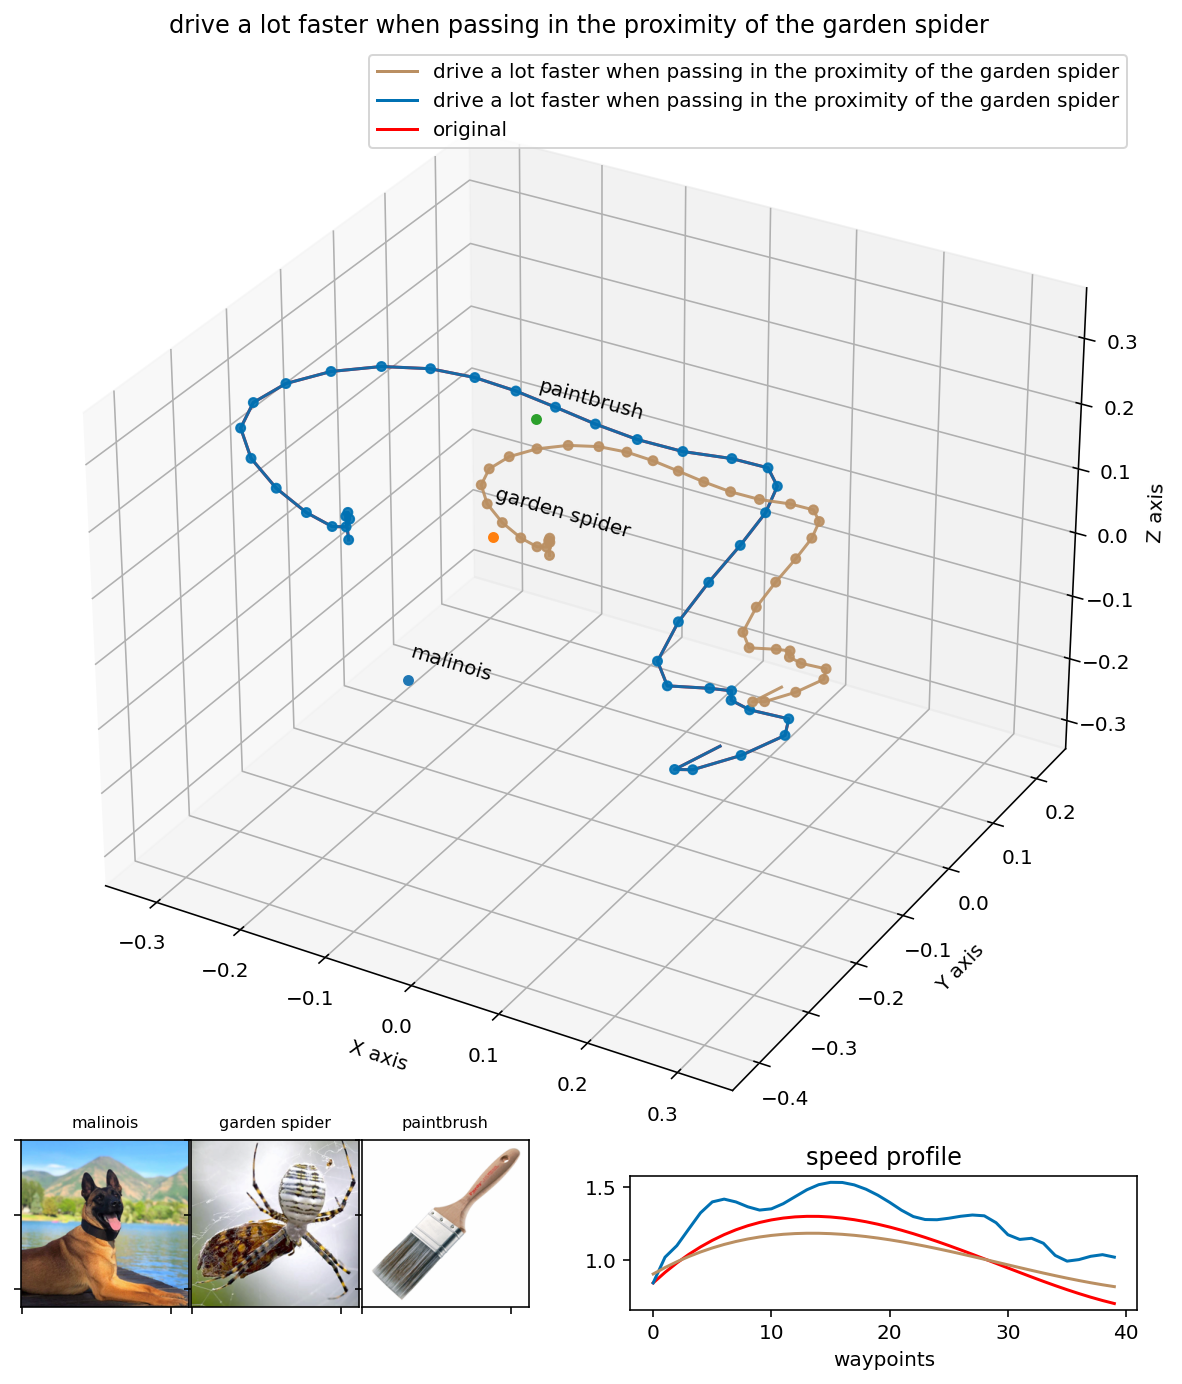

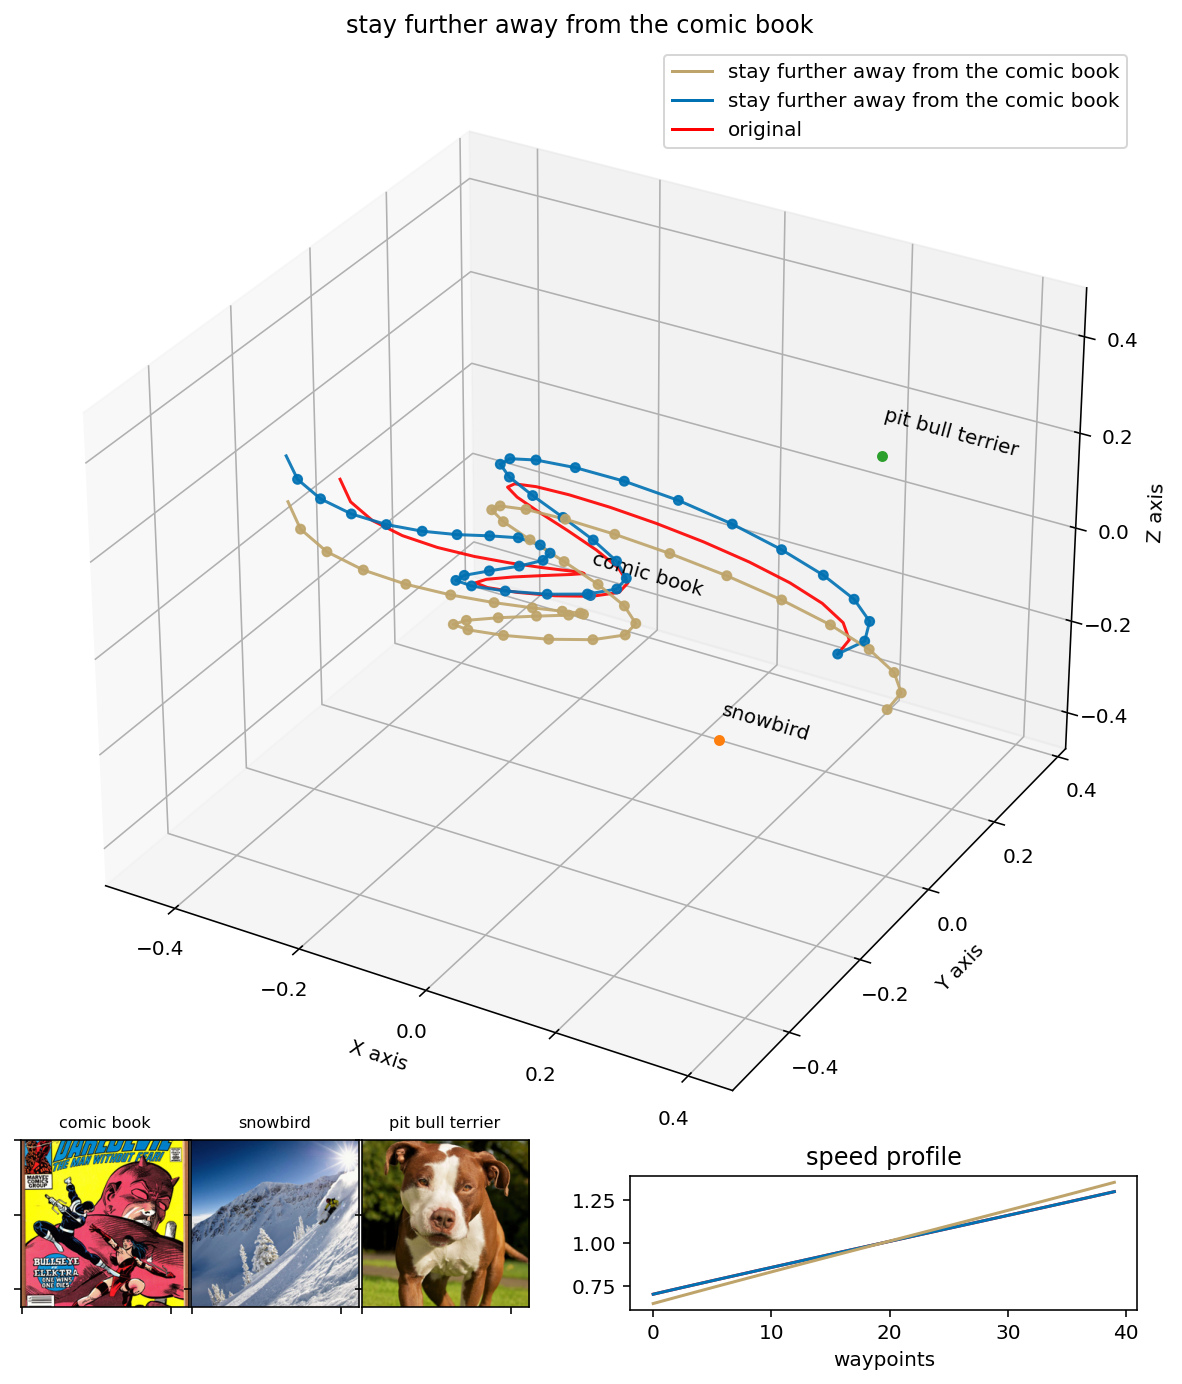

In [12]:

test_dataset = tf.data.Dataset.from_tensor_slices((prepare_x(X_test,traj_indices,obj_poses_indices),
                                                  list_to_wp_seq(y_test,d=4),
                                                  X_test[:,embedding_indices])).batch(3)
x_t, y_t= next(generator(test_dataset))
data_array = np.array(data)[indices_test[:3]]

%matplotlib inline
show_data4D(data_array, pred=x_t[0][:,6:,:],color_traj=False, image_loader=mr.image_loader, change_img_base=["/mnt/tumdata/image_dataset/", image_dataset_folder])


In [ ]:
result_eval = model.evaluate((x_test_new, y_test_new[:,:-1,:], emb_test_new), y_test_new[:,1:,:])[0]

g = generator(test_dataset,stop=True,augment=False)
x_t, y_t = next(g)
pred = generate(model ,x_t, traj_n=traj_n, start_index=6).numpy()
print(pred.shape)
result_gen = np.average((y_t - pred[:,1:,:])**2)

print("Test loss w generation: ",result_gen)



In [7]:
print("naive predictor")
print(np.average((y_t - x_t[0][:,7:,:])**2))

print("MSE naive cartesian:",np.average((y_t[:,:,:3] - x_t[0][:,7:,:3])**2))
print("MSE model cartesian:",np.average((y_t[:,:,:3] - pred[:,1:,:3])**2))
print("MSE naive vel:",np.average((y_t[:,:,3:] - x_t[0][:,7:,3:])**2))
print("MSE model vel:",np.average((y_t[:,:,3:] - pred[:,1:,3:])**2))


naive predictor
0.005762455522215233
MSE naive cartesian: 0.001543657398243346
MSE model cartesian: 0.001320108700302601
MSE naive vel: 0.01841884989413089
MSE model vel: 0.011582194697996328


In [1]:
%matplotlib qt
plt.close('all')
indices = np.random.choice(range(len(indices_test)), 6)
# pred_t = np.transpose(pred[:,:,:2],[0,2,1])

# indices = [2047, 10147, 10805] #cartesian
# indices = [189, 9998, 4658, 2734] #speed
# indices = [11080, 3943, 13417, 9555, 7099] #dist

data_array = np.array(data)[indices_test[indices]]
# indices_test_by_change = {'dist':[], 'cartesian':[], 'speed':[]}
# for d,i in zip(np.array(data)[indices_test], indices_test):
#     indices_test_by_change[d["change_type"]].append(i)

# change_type = 'dist'
# base_indices = np.array(indices_test_by_change[change_type])
# indices = np.random.choice(range(len(base_indices)),6)
# data_array = np.array(data)[base_indices[indices]]

# indices = [2047, 10147, 10805,13417] #cartesian
indices = [189, 9998, 4658, 2734, 9555] #speed
# indices = [11080, 3943, 7099, 13440] #dist
print(indices)
# pred_t = np.transpose(pred[:,:,:2],[0,2,1])
show_data4D(data_array, pred=pred[indices],image_loader=mr.image_loader, color_traj=False, change_img_base=["/home/mirmi/Arthur/dataset/","/home/tum/data/image_dataset/"])

NameError: name 'plt' is not defined

In [1]:
model.summary()

NameError: name 'model' is not defined

In [5]:
%matplotlib qt
indices = np.array(range(5))

pred = generate(model ,(x_test_new[indices], y_test_new[indices][:,:-1,:], emb_test_new[indices]), traj_n=traj_n, start_index=6).numpy()
print(pred.shape)
# indices = np.random.choice(range(len(indices_test)), 6)

data_array = np.array(data)[indices_test[indices]]
show_data4D(data_array, pred=pred[indices],image_loader=mr.image_loader, color_traj=False)

NameError: name 'model' is not defined

## Plot Attention Heatmaps

In [7]:
%matplotlib qt
indices = np.array(range(2))

pred = generate(model ,(x_test_new[indices], y_test_new[indices][:,:-1,:], emb_test_new[indices]), traj_n=traj_n, start_index=6).numpy()
print(pred.shape)
# indices = np.random.choice(range(len(indices_test)), 6)

data_array = np.array(data)[indices_test[indices]]
show_data4D(data_array, pred=pred[indices],image_loader=mr.image_loader, color_traj=False)

  0%|          | 0/39 [00:00<?, ?it/s]

1/1 [==============================] - 0s 152ms/step


  3%|▎         | 1/39 [00:00<00:06,  5.67it/s]

1/1 [==============================] - 0s 132ms/step


  5%|▌         | 2/39 [00:00<00:06,  6.14it/s]

1/1 [==============================] - 0s 134ms/step


  8%|▊         | 3/39 [00:00<00:05,  6.31it/s]

1/1 [==============================] - 0s 129ms/step


 10%|█         | 4/39 [00:00<00:05,  6.46it/s]

1/1 [==============================] - 0s 135ms/step


 13%|█▎        | 5/39 [00:00<00:05,  6.47it/s]

1/1 [==============================] - 0s 139ms/step


 15%|█▌        | 6/39 [00:00<00:05,  6.40it/s]

1/1 [==============================] - 0s 136ms/step


 18%|█▊        | 7/39 [00:01<00:05,  6.39it/s]

1/1 [==============================] - 0s 139ms/step


 21%|██        | 8/39 [00:01<00:04,  6.32it/s]

1/1 [==============================] - 0s 164ms/step


 23%|██▎       | 9/39 [00:01<00:04,  6.02it/s]

1/1 [==============================] - 0s 136ms/step


 26%|██▌       | 10/39 [00:01<00:04,  6.12it/s]

1/1 [==============================] - 0s 140ms/step


 28%|██▊       | 11/39 [00:01<00:04,  6.16it/s]

1/1 [==============================] - 0s 140ms/step


 31%|███       | 12/39 [00:01<00:04,  6.19it/s]

1/1 [==============================] - 0s 134ms/step


 33%|███▎      | 13/39 [00:02<00:04,  6.28it/s]

1/1 [==============================] - 0s 141ms/step


 36%|███▌      | 14/39 [00:02<00:03,  6.26it/s]

1/1 [==============================] - 0s 143ms/step


 38%|███▊      | 15/39 [00:02<00:03,  6.22it/s]

1/1 [==============================] - 0s 139ms/step


 41%|████      | 16/39 [00:02<00:03,  6.20it/s]

1/1 [==============================] - 0s 143ms/step


 44%|████▎     | 17/39 [00:02<00:03,  6.18it/s]

1/1 [==============================] - 0s 147ms/step


 46%|████▌     | 18/39 [00:02<00:03,  6.11it/s]

1/1 [==============================] - 0s 146ms/step


 49%|████▊     | 19/39 [00:03<00:03,  6.09it/s]

1/1 [==============================] - 0s 143ms/step


 51%|█████▏    | 20/39 [00:03<00:03,  6.09it/s]

1/1 [==============================] - 0s 142ms/step


 54%|█████▍    | 21/39 [00:03<00:02,  6.12it/s]

1/1 [==============================] - 0s 143ms/step


 56%|█████▋    | 22/39 [00:03<00:02,  6.12it/s]

1/1 [==============================] - 0s 141ms/step


 59%|█████▉    | 23/39 [00:03<00:02,  6.12it/s]

1/1 [==============================] - 0s 143ms/step


 62%|██████▏   | 24/39 [00:03<00:02,  6.07it/s]

1/1 [==============================] - 0s 143ms/step


 64%|██████▍   | 25/39 [00:04<00:02,  6.09it/s]

1/1 [==============================] - 0s 153ms/step


 67%|██████▋   | 26/39 [00:04<00:02,  5.90it/s]

1/1 [==============================] - 0s 146ms/step


 69%|██████▉   | 27/39 [00:04<00:02,  5.94it/s]

1/1 [==============================] - 0s 151ms/step


 72%|███████▏  | 28/39 [00:04<00:01,  5.90it/s]

1/1 [==============================] - 0s 148ms/step


 74%|███████▍  | 29/39 [00:04<00:01,  5.92it/s]

1/1 [==============================] - 0s 196ms/step


 77%|███████▋  | 30/39 [00:04<00:01,  5.45it/s]

1/1 [==============================] - 0s 150ms/step


 79%|███████▉  | 31/39 [00:05<00:01,  5.53it/s]

1/1 [==============================] - 0s 149ms/step


 82%|████████▏ | 32/39 [00:05<00:01,  5.62it/s]

1/1 [==============================] - 0s 144ms/step


 85%|████████▍ | 33/39 [00:05<00:01,  5.73it/s]

1/1 [==============================] - 0s 151ms/step


 87%|████████▋ | 34/39 [00:05<00:00,  5.76it/s]

1/1 [==============================] - 0s 141ms/step


 90%|████████▉ | 35/39 [00:05<00:00,  5.88it/s]

1/1 [==============================] - 0s 159ms/step


 92%|█████████▏| 36/39 [00:05<00:00,  5.79it/s]

1/1 [==============================] - 0s 148ms/step


 95%|█████████▍| 37/39 [00:06<00:00,  5.85it/s]

1/1 [==============================] - 0s 150ms/step


 97%|█████████▋| 38/39 [00:06<00:00,  5.85it/s]

1/1 [==============================] - 0s 150ms/step


100%|██████████| 39/39 [00:06<00:00,  6.01it/s]

(2, 40, 4)
[array([[-0.02464634, -0.0427573 , -0.23094565, -0.16262556],
       [-0.08552366, -0.10031735, -0.15221617, -0.19210523],
       [-0.13898784, -0.1093005 , -0.07965026, -0.21770939],
       [-0.17870851, -0.08506388, -0.02267568, -0.23957585],
       [-0.20434149, -0.03741677,  0.01892852, -0.2578424 ],
       [-0.21726936,  0.02861229,  0.04830049, -0.27264687],
       [-0.21867374,  0.10805358,  0.06759572, -0.28412706],
       [-0.21021167,  0.19454226,  0.07836372, -0.29242077],
       [-0.19488069,  0.27995379,  0.08233544, -0.29766582],
       [-0.18820436,  0.34326035,  0.08729033, -0.3       ],
       [-0.23083676,  0.34128164,  0.11130392, -0.29956113],
       [-0.28399797,  0.29356706,  0.14487876, -0.29648702],
       [-0.29857426,  0.23250837,  0.17812037, -0.29091546],
       [-0.26687606,  0.17265745,  0.21074252, -0.28298428],
       [-0.2280921 ,  0.1090235 ,  0.2430953 , -0.27283127],
       [-0.21958543,  0.03561387,  0.26888214, -0.26059425],
       [-0.2

[array([[-0.07181058, -0.3       , -0.20700188, -0.3       ],
       [-0.14837403, -0.29126575, -0.24781817, -0.28509845],
       [-0.20775585, -0.26573529, -0.27977378, -0.27009141],
       [-0.25103283, -0.22958362, -0.3023028 , -0.25498536],
       [-0.27802579, -0.18664728, -0.31503994, -0.23978679],
       [-0.29344508, -0.14282151, -0.32015725, -0.22450221],
       [-0.30576249, -0.10413313, -0.32028871, -0.20913809],
       [-0.31561834, -0.07031734, -0.31635631, -0.19370094],
       [-0.32410172, -0.04101543, -0.30924591, -0.17819725],
       [-0.33142281, -0.01559093, -0.29913565, -0.1626335 ],
       [-0.33823675,  0.00654041, -0.28615136, -0.1470162 ],
       [-0.34484358,  0.02595495, -0.27027725, -0.13135183],
       [-0.35089182,  0.04311225, -0.25136234, -0.11564689],
       [-0.35672612,  0.05828492, -0.22956642, -0.09990786],
       [-0.36222538,  0.07158595, -0.20494516, -0.08414125],
       [-0.36665087,  0.08296918, -0.17750342, -0.06835354],
       [-0.37017859,  0

## ROS simulations

In [8]:
import rospy
from nav_msgs.msg import Path
from geometry_msgs.msg import PoseStamped


# rospack = rospkg.RosPack()
# pkg_path = rospack.get_path('NL_trajectory_reshaper')

rospy.init_node('traj_streamer', anonymous=True)
traj_pub = rospy.Publisher("/simple_traj", Path)    



In [118]:

def publish_simple_traj(traj,objs, pub, scale=1.0, frame_id="original"):
    msg = Path()
    msg.header.frame_id = frame_id
    msg.header.stamp = rospy.Time.now()
    for wp in np.concatenate([objs,traj],axis=0):
        ps = PoseStamped()

        ps.pose.position.x = wp[0]*scale
        ps.pose.position.y = wp[1]*scale
        ps.pose.position.z = 1.0+wp[2]*scale
        ps.pose.orientation.w = 1.0+wp[3]*scale

        msg.poses.append(ps)
    
    if len( msg.poses)>0:
        print("traj len:",len( msg.poses))
        pub.publish(msg)
    else:
        print("no traj to publish")


def interpolate_traj(wps,traj_n=40):
    #create spline function
    f, u = interpolate.splprep([wps[:,0],wps[:,1],wps[:,2]], s=0)
    xint,yint,zint= interpolate.splev(np.linspace(0, 1, traj_n), f)

    tck,u = interpolate.splprep([np.linspace(0,1,len(wps[:,3])), wps[:,3]])
    velint_x, velint = interpolate.splev(np.linspace(0, 1, traj_n), tck)

    traj = np.stack([xint,yint,zint,velint],axis=1)+offset
    return traj


def norm_traj_and_objs(t, o, margin=0.45):
    pts_ = np.concatenate([o,t])

    vel = pts_[:,3:]
    pts = pts_[:,:3]

    vel_min = np.min(vel,axis = 0)
    vel_max = np.max(vel,axis = 0)
    vel_norm = np.max(np.abs(vel_max-vel_min))
    if vel_norm > 1e-10:
        vel = ((vel-(vel_max-vel_min)/2)/vel_norm)*(1-margin)

    else:
        vel = vel-vel_min

    pts_min = np.min(pts,axis = 0)
    pts_max = np.max(pts,axis = 0)
    pts_norm = np.max(np.abs(pts_max-pts_min))

    # pts  = ((pts-pts_min)/pts_norm)*(1-margin)+margin/2-0.5
    pts  = ((pts-(pts_max-pts_min)/2)/pts_norm)*(1-margin)

    pts_new= np.concatenate([pts,vel],axis=-1)
    o_new = pts_new[:o.shape[0],:]
    t_new = pts_new[o.shape[0]:,:]

    return t_new, o_new, [pts_norm, (pts_max-pts_min)/2,vel_norm, (vel_max-vel_min)/2, margin]

def rescale(pts_, factor_list):

    vel = pts_[:,3:]
    pts = pts_[:,:3]

    pts_norm, pts_avr,vel_norm, vel_avr, margin = factor_list
    pts = pts/(1-margin)*pts_norm+pts_avr
    vel = vel/(1-margin)*vel_norm+vel_avr
    pts_new= np.concatenate([pts,vel],axis=-1)

    return pts_new

# -------------- drone simulation ---------------

obj_poses = np.array([[1,0,0.0,0],[0,1,0,0],[1,1,-0.5,0],[0,0,0,0],[0,0,0,0],[0,0,0,0]])
obj_poses_offset = np.array([[0,0,-1,0],[0,0,-0.9,0],[0,0,0,0],[0,0,0,0],[0,0,0,0],[0,0,0,0]])

base_wp = np.array([[0,0,0,0.3],[0.5,0.5,0,0.1],[1,1,0.3,0.0],[1.5,1.5,0.2,0.1],[0.5,1.7,0.1,0.2]])
offset = np.array([0,0,-0.3,0])
obj_names = ["human","plant", "dinning table"]
# text = "keep a bigger distance from the actor" #distance
# text = "go to the bottom"                      #cartesian
text = "fly slower when next to the table"       #speed
# text = "avoid more the dinning table"          #new vocab



# -------------- hexapod simulation ---------------

# obj_poses = np.array([[1,0,-0.0,0],[0,1,-0.0,0],[1.5,1,0.05,0],[0,0,0,0],[0,0,0,0],[0,0,0,0]])
# obj_poses_offset = np.array([[0,0,-1.0,0],[0,0,-0.9,0],[0,0,-.92,0],[0,0,0,0],[0,0,0,0],[0,0,0,0]])
# base_wp = np.array([[0,0,0,0],[0.7,0.5,0.0,0.01],[1,1,0.0,0.01],[1.5,1.5,0,0],[2.0,1.0,0.0,0.01]])
# offset = np.array([0,0,0,0])
# obj_names = ["bowl", "plant", "computer"]
# text = "go much faster in the suroundings of the plant" #speed
# text = "stay further away from the computer"            #distance
# text = "stay on the back"                               #cartesian




traj = interpolate_traj(base_wp,traj_n=traj_n)
publish_simple_traj(traj,obj_poses+obj_poses_offset,traj_pub)

traj_, obj_poses_, factor_list = norm_traj_and_objs(traj, obj_poses)
obj_poses_ = obj_poses_[:,:3]

d = np2data(traj_, obj_names, obj_poses_, text)[0]
pred, traj_in = mr.apply_interaction(model, d, text,  label=False)

data_array = np.array([d])
# %matplotlib qt
show_data4D(data_array, pred=pred, color_traj=False)
# 
traj_new = rescale(pred[0], factor_list)
publish_simple_traj(traj_new,obj_poses+obj_poses_offset,traj_pub, frame_id="new")


traj len: 46
DONE - computing embeddings and similarity vectors 
[[ 0.07222365 -0.275      -0.07998176]
 [-0.240991    0.03821465 -0.07998176]
 [ 0.07222365  0.03821465 -0.23658908]
 [-0.240991   -0.275      -0.07998176]
 [-0.240991   -0.275      -0.07998176]
 [-0.240991   -0.275      -0.07998176]]
DONE - concatenating 
(1, 952)


  0%|          | 0/39 [00:00<?, ?it/s]

1/1 [==============================] - 0s 21ms/step


  8%|▊         | 3/39 [00:00<00:01, 21.71it/s]

1/1 [==============================] - 0s 19ms/step


 15%|█▌        | 6/39 [00:00<00:01, 21.62it/s]

1/1 [==============================] - 0s 20ms/step


 23%|██▎       | 9/39 [00:00<00:01, 21.73it/s]

1/1 [==============================] - 0s 19ms/step


 31%|███       | 12/39 [00:00<00:01, 22.29it/s]

1/1 [==============================] - 0s 21ms/step


 38%|███▊      | 15/39 [00:00<00:01, 22.19it/s]

1/1 [==============================] - 0s 19ms/step


 46%|████▌     | 18/39 [00:00<00:00, 22.02it/s]

1/1 [==============================] - 0s 20ms/step


 54%|█████▍    | 21/39 [00:00<00:00, 22.39it/s]

1/1 [==============================] - 0s 20ms/step


 62%|██████▏   | 24/39 [00:01<00:00, 22.22it/s]

1/1 [==============================] - 0s 21ms/step


 69%|██████▉   | 27/39 [00:01<00:00, 22.37it/s]

1/1 [==============================] - 0s 21ms/step


 77%|███████▋  | 30/39 [00:01<00:00, 22.51it/s]

1/1 [==============================] - 0s 20ms/step


 85%|████████▍ | 33/39 [00:01<00:00, 22.27it/s]

1/1 [==============================] - 0s 20ms/step


 92%|█████████▏| 36/39 [00:01<00:00, 22.01it/s]

1/1 [==============================] - 0s 21ms/step


100%|██████████| 39/39 [00:01<00:00, 22.21it/s]

[array([[-2.40990998e-01, -2.75000000e-01, -1.73946152e-01,
         2.75000000e-01],
       [-2.24393770e-01, -2.62236893e-01, -2.26697594e-01,
         2.29759976e-01],
       [-2.01882750e-01, -2.46360272e-01, -2.46118918e-01,
         1.76840976e-01],
       [-1.80987790e-01, -2.25315556e-01, -2.58220732e-01,
         1.27590805e-01],
       [-1.62852481e-01, -2.02871993e-01, -2.65606970e-01,
         8.29710513e-02],
       [-1.46662369e-01, -1.82317570e-01, -2.66826391e-01,
         4.15104441e-02],
       [-1.31258756e-01, -1.64986014e-01, -2.63995230e-01,
         2.84958165e-03],
       [-1.14889778e-01, -1.49169087e-01, -2.57424146e-01,
        -3.20371352e-02],
       [-9.88087133e-02, -1.33359939e-01, -2.49109507e-01,
        -6.38981313e-02],
       [-8.34682062e-02, -1.17077023e-01, -2.39186406e-01,
        -9.38096866e-02],
       [-6.76682219e-02, -1.00220807e-01, -2.27009118e-01,
        -1.19354434e-01],
       [-5.01760729e-02, -8.29109550e-02, -2.14709714e-01,
     

## Plot Attention Heatmaps

In [12]:

# m.layers[3].att_weights
# print(tf.executing_eagerly())
tf.config.run_functions_eagerly(True)

print(tf.executing_eagerly())

x_train_new, y_train_new = prepare_x(X_train), list_to_wp_seq(y_train,d=4)
emb_train_new = X_train[:,embedding_indices]


print(x_test_new.shape)
samples = x_test_new.shape[0]
pred_train = model.predict((x_test_new[:samples,:,:], y_test_new[:samples,:-1,:], emb_test_new[:samples,:]))


True
(13860, 46, 4)
434/434 [==============================] - 119s 274ms/step


In [190]:
%matplotlib inline
plt.close("all")
def _lower_triangular_mask(shape):
    """Creates a lower-triangular boolean mask over the last 2 dimensions."""
    row_index = np.cumsum(
        np.ones(shape=shape), axis=-2)
    col_index = np.cumsum(
        np.ones(shape=shape), axis=-1)
    return np.greater_equal(row_index, col_index)

def show_heatmaps(matrices,
                  xlabel,
                  ylabel,
                  titles=None,
                  figsize=(15, 6),
                  cmap='Reds',
                  causal = True):
    num_rows, num_cols = matrices.shape[0], matrices.shape[1]
    fig, axes = plt.subplots(num_rows,
                             num_cols,
                             figsize=figsize,
                             sharex=True,
                             sharey=True,
                             squeeze=False)
    

    for i, (row_axes, row_matrices) in enumerate(zip(axes, matrices)):
        for j, (ax, matrix) in enumerate(zip(row_axes, row_matrices)):
            att = matrix.numpy()
            if causal:
                att[_lower_triangular_mask(att.shape)==False] = 0
            pcm = ax.imshow(att, cmap=cmap)
            if i == num_rows - 1:
                ax.set_xlabel(xlabel)
            if j == 0:
                ax.set_ylabel(ylabel)
            if titles:
                ax.set_title(titles[j])
    fig.colorbar(pcm, ax=axes, shrink=0.6)



enc_att = model.layers[3]._layers[2][0].multi_head_attention.distribution
enc_att = tf.math.reduce_sum(enc_att,axis=(0,1))
enc_att = tf.reshape(enc_att,(1,1,enc_att.shape[-2],enc_att.shape[-1]))

dec_layers = model.layers[4]._layers[3]
att_list = []
s_att_list = []
enc_att_list = []

for i in range(len(dec_layers)):

    s_att = dec_layers[i].multi_head_attention1.distribution 
    att = dec_layers[i].multi_head_attention2.distribution 

    s_att = tf.math.reduce_sum(s_att,axis=(0,1))
    att = tf.math.reduce_sum(att,axis=(0,1))
    
    s_att = tf.reshape(s_att,(1,1,s_att.shape[-2],s_att.shape[-1]))
    att = tf.reshape(att,(1,1,att.shape[-2],att.shape[-1]))


    s_att_list.append(s_att)
    att_list.append(att)

att_list=tf.concat(att_list,axis=1)
s_att_list=tf.concat(s_att_list,axis=1)
# dec_att = tf.concat([s_att_list,att_list],axis=0)
# print(dec_att.shape)


    # att = tf.reshape(att,(att.shape[0],1,att.shape[-2],att.shape[-1]))
    # print(att.shape)
# with tf.compat.v1.Session().as_default() as sess:  print(att.eval()) 
show_heatmaps(enc_att, causal =False,xlabel='Keys', ylabel='Queries',figsize=(7, 5))

show_heatmaps(s_att_list, causal =True,xlabel='Keys', ylabel='Queries',figsize=(15, 5))
show_heatmaps(att_list, causal =False,xlabel='Keys', ylabel='Queries',figsize=(15, 5))


AttributeError: 'Encoder' object has no attribute '_layers'

In [ ]:
show_heatmaps(att_list[:,4:5,:,:], causal =False,xlabel='Keys', ylabel='Queries',figsize=(15, 10))


## Text augmentation

In [14]:
from transformers import PegasusForConditionalGeneration, PegasusTokenizer 
import torch
import gc

In [2]:
from transformers import BartForConditionalGeneration, BartTokenizer
import torch

input_sentence = "They were there to enjoy us and they were there to pray for us."

model = BartForConditionalGeneration.from_pretrained('eugenesiow/bart-paraphrase')
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")

model = model.to(device)
tokenizer = BartTokenizer.from_pretrained('eugenesiow/bart-paraphrase')
batch = tokenizer(input_sentence, return_tensors='pt')
generated_ids = model.generate(batch['input_ids'])
generated_sentence = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)

print(generated_sentence)

Downloading:   0%|          | 0.00/332 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/780k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/239 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.29M [00:00<?, ?B/s]

2022-06-13 12:37:41.670970: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


['They were there to enjoy us and to pray for us.']


In [414]:
ds_size_factor = 0.01
_X_train = X_train[:int(ds_size_factor*X_train.shape[0]),:]
_y_train = y_train[:int(ds_size_factor*y_train.shape[0]),:]
_indices_train = indices_train[:int(ds_size_factor*indices_train.shape[0])]


_X_valid = X_valid[:int(ds_size_factor*X_valid.shape[0]),:]
_y_valid = y_valid[:int(ds_size_factor*y_valid.shape[0]),:]
_indices_valid = indices_val[:int(ds_size_factor*indices_val.shape[0])]

print(_X_valid.shape)
print(_y_valid.shape)
print(_indices_valid.shape)

(69, 952)
(69, 160)
(69,)



class Text_augmentor():
    def __init__(self, net="pegasus"):
        
        self.net=net
        # self.torch_device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.torch_device = 'cuda'

        if self.net == "pegasus": 

            self.model_name = 'tuner007/pegasus_paraphrase' 
            self.tokenizer = PegasusTokenizer.from_pretrained(self.model_name)
            self.model = PegasusForConditionalGeneration.from_pretrained(self.model_name).to(self.torch_device)
        elif self.net == "bart":
            self.model_name = 'eugenesiow/bart-paraphrase'
            self.tokenizer = BartTokenizer.from_pretrained(self.model_name)
            self.model = BartForConditionalGeneration.from_pretrained(self.model_name).to(self.torch_device)

    def augment(self, input_text: list, num_return_sequences: int, num_beams: int):

        if self.net == "pegasus": 
            batch = self.tokenizer.prepare_seq2seq_batch(input_text, truncation=True, padding='longest', return_tensors='pt').to(self.torch_device)
            translated = self.model.generate(**batch, max_length = 60, num_beams = num_beams, num_return_sequences = num_return_sequences, temperature = 1.5)
            tgt_text = self.tokenizer.batch_decode(translated, skip_special_tokens = True)
            return tgt_text
        elif self.net == "bart":
            batch = self.tokenizer.prepare_seq2seq_batch(input_text, truncation=True, padding='longest', return_tensors='pt').to(self.torch_device)

            # batch = tokenizer(input_sentence, return_tensors='pt')
            generated_ids = self.model.generate(**batch, num_beams = num_beams, num_return_sequences = num_return_sequences,)
            # generated_ids = self.model.generate(**batch, max_length = 60, num_beams = num_beams, num_return_sequences = num_return_sequences, temperature = 1.5)

            generated_sentence = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)
            return generated_sentence

text_ag = Text_augmentor(net = "bart")


In [37]:
n_factor = 3
n_samples = 30

# text_index = np.random.choice(range(n_factor),(n_samples))
# text_list = [d["text"] for d in data]
# text_all = np.array(text_ag.augment(text_list[:n_samples],n_factor,10)).reshape(-1,n_factor)
# text_new = [(text_list[i], random.choice(ts)) for i,ts in enumerate(text_all)]

text_list_o = [d["text"] for d in data]

def augment_text(text_ag, data_raw):
    text_list = [d["text"] for d in data_raw]
    
    n_factor = 3
    n_samples = 50
    new_text_list = []
    count=0
    while count < len(text_list):

        

        lower_i = count
        higher_i = min(count+n_samples,len(text_list))


        text_all = np.array(text_ag.augment(text_list[lower_i:higher_i],n_factor,10)).reshape(-1,n_factor)
        new_text_list = new_text_list + [random.choice(ts) for i,ts in enumerate(text_all)]
        print(higher_i, end=" ")
        count+=n_samples
        for i in range(lower_i,higher_i):
            data_raw[i]["text"] = new_text_list[i]
        
        gc.collect()
        torch.cuda.empty_cache()
    
    return data_raw
data_new = augment_text(text_ag,data[200:300])

50 100 

In [64]:
i =random.choice(range(200,300))
print(text_list_o[i], "\n",data_new[i-200]["text"])

go a lot slower while passing in the surrounding of the barbershop 
 Passengers go a lot slower while passing in the surrounding area of the barbershop.


In [35]:
text_new[np.ix_(np.arange(n_samples),text_index)]

IndexError: index 3 is out of bounds for axis 1 with size 3

In [ ]:
from src.TF4D_ import *
tf.config.run_functions_eagerly(False)

raw_input_shape = ((None, 46, 4), (None, 39, 4), (None, 792))
# print((x_test_new.shape, y_test_new[:,:-1,:].shape, emb_test_new.shape))

param = {'num_layers_enc': 2, 'num_layers_dec': 4, 'd_model': 256, 'dff': 512, 'num_heads': 8, 'dropout_rate': 0.1, 'wp_d': 4, 'bs': 16, 'dense_n': 512, 'num_dense': 3, 'concat_emb': True, 'features_n': 792, 'optimizer': 'adam', 'norm_layer': True, 'activation': 'linear'}
m = get_model(**param)

m.build((x_test_new, y_test_new[:,:-1,:], emb_test_new))
m.predict((x_test_new, y_test_new[:,:-1,:], emb_test_new))
m.fit((x_test_new, y_test_new[:,:-1,:], emb_test_new),y_test_new[:,1:,:])
# m.layers[3].model().layers[1].output
# m.layers[3].att_weights
# tf.keras.Model(inputs=[new_model.input], outputs=new_model.get_layer("encoder_2").output).summary()


In [ ]:
tf.keras.utils.plot_model(model, expand_nested=True, show_shapes=True)